In [4]:
import os
import shutil
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam
from collections import deque
from google.colab import drive
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

In [ ]:
drive.mount('/content/drive')

In [6]:
# Rutas a las carpetas de categorías
categorias = ['ambulancia', 'bus', 'carro_bomberos', 'rover']
dataset = []

for categoria in categorias:
    categoria_path = f'/content/drive/MyDrive/images_dataset/training/{categoria}'

    for imagen_file in os.listdir(categoria_path):
        imagen_path = os.path.join(categoria_path, imagen_file)
        imagen = load_img(imagen_path, target_size=(150, 150))
        imagen_array = img_to_array(imagen) / 255.0  # Normalizar entre 0 y 1
        dataset.append({'image': imagen_array, 'category': categorias.index(categoria)})

# Implementación básica del modelo DQN
def build_dqn_model(input_shape, num_actions):
    model = Sequential()
    model.add(Flatten(input_shape=input_shape))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(num_actions, activation='linear'))
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model

# Implementación básica del entorno
class SimpleEnvironment:
    def __init__(self, dataset):
        self.dataset = dataset
        self.current_index = 0

    def reset(self):
        self.current_index = 0
        return self.dataset[self.current_index]['image']

    def step(self, action):
        # Obtener la recompensa basada en la acción tomada
        reward = self.calculate_reward(action)

        # Actualizar el índice para obtener la siguiente imagen en el próximo paso
        self.current_index += 1

        # Obtener la siguiente imagen
        next_state = self.dataset[self.current_index]['image']

        return next_state, reward

    def calculate_reward(self, action):
        # Implementar la lógica para calcular la recompensa basada en la acción y la verdad
        # Puedes comparar la acción con la categoría real de la imagen actual
        return 1 if action == self.dataset[self.current_index]['category'] else -1

# Parámetros
num_actions = 4  # Número de categorías de vehículos
state_shape = (150, 150, 3)  # Ajustar según las dimensiones de tus imágenes
batch_size = 32
num_episodes = 100
max_steps_per_episode = 100

# Crear un entorno y un modelo DQN
env = SimpleEnvironment(dataset)  # Ajustar según tus datos
model = build_dqn_model(input_shape=state_shape, num_actions=num_actions)

# Bucle de entrenamiento
for episode in range(num_episodes):
    state = env.reset()
    state = np.reshape(state, (1,) + state_shape)
    total_reward = 0

    for step in range(max_steps_per_episode):
        # Elige una acción con el modelo DQN
        action = np.argmax(model.predict(state))

        # Toma la acción en el entorno y obtén el siguiente estado y recompensa
        next_state, reward = env.step(action)
        next_state = np.reshape(next_state, (1,) + state_shape)

        # Actualiza el modelo DQN con la experiencia
        target = reward + 0.95 * np.amax(model.predict(next_state)[0])
        target_f = model.predict(state)
        target_f[0][action] = target
        model.fit(state, target_f, epochs=1, verbose=0)

        state = next_state
        total_reward += reward

        if total_reward == 1 or total_reward == -1:
            # La recompensa indica que la predicción fue correcta o incorrecta
            print(f"Episodio {episode + 1}, Paso {step + 1}, Recompensa: {total_reward}")
            break

# Guardar el modelo
model.save('/content/modelo/modelo_rl.h5')
model.save_weights('/content/modelo/pesos_rl.h5')


1/1 [==============================] - 0s 31ms/step
Episodio 1, Paso 1, Recompensa: 1
1/1 [==============================] - 0s 38ms/step
Episodio 2, Paso 1, Recompensa: 1
1/1 [==============================] - 0s 38ms/step
Episodio 3, Paso 1, Recompensa: -1
1/1 [==============================] - 0s 36ms/step
Episodio 4, Paso 1, Recompensa: -1
1/1 [==============================] - 0s 32ms/step
Episodio 5, Paso 1, Recompensa: -1
1/1 [==============================] - 0s 37ms/step
Episodio 6, Paso 1, Recompensa: -1
1/1 [==============================] - 0s 41ms/step
Episodio 7, Paso 1, Recompensa: -1
1/1 [==============================] - 0s 39ms/step
Episodio 8, Paso 1, Recompensa: -1
1/1 [==============================] - 0s 61ms/step
Episodio 9, Paso 1, Recompensa: -1
1/1 [==============================] - 0s 37ms/step
Episodio 10, Paso 1, Recompensa: -1
1/1 [==============================] - 0s 52ms/step
Episodio 11, Paso 1, Recompensa: -1
1/1 [==============================] - 0s 3

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 141ms/step


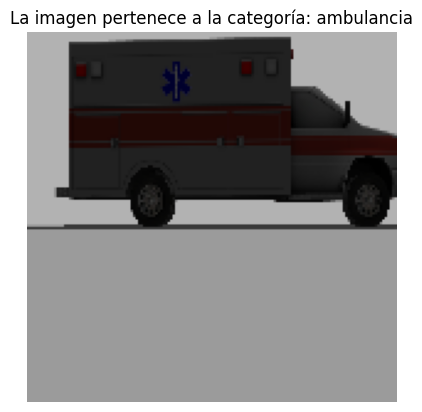

In [16]:
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt

# Cargar el modelo desde el archivo .h5
modelo_rl = load_model('/content/modelo/modelo_rl.h5')

# Función para preprocesar una imagen y hacer una predicción
def predecir_imagen(ruta_imagen):
    imagen = load_img(ruta_imagen, target_size=(150, 150))
    imagen_array = img_to_array(imagen) / 255.0  # Normalizar entre 0 y 1
    imagen_array = np.reshape(imagen_array, (1, 150, 150, 3))  # Ajustar las dimensiones
    prediccion = modelo_rl.predict(imagen_array)
    categoria_predicha = np.argmax(prediccion)
    return imagen, categoria_predicha

# Ruta de una nueva imagen para predecir
ruta_nueva_imagen = '/content/drive/MyDrive/images_dataset/training/ambulancia/image_424.png'

# Obtener la predicción
imagen, categoria_predicha = predecir_imagen(ruta_nueva_imagen)

# Mostrar la imagen
plt.imshow(imagen)
plt.title(f"La imagen pertenece a la categoría: {categoria_real}")
plt.axis('off')
plt.show()
